In [1]:
# loading the required libraries.
import time
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import Imagenette
from tqdm.notebook import tqdm, trange
from torch.utils.tensorboard import SummaryWriter

In [2]:
# loading the imagenette data
def get_imagenette_data():

  # train and test transforms to crop, resize and to normalize the image data
  train_transform = transforms.Compose([
      transforms.CenterCrop(160),
      transforms.Resize(64),
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
      transforms.Grayscale()

  ])
  test_transform = transforms.Compose([
      transforms.CenterCrop(160),
      transforms.Resize(64),
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
      transforms.Grayscale()
  ])

  # loading the data from the torchvision datasets
  trainset = Imagenette("data/imagenette/train/", split="train", size="160px", download=True, transform=train_transform)

  # deviding the data into train and the val datasets
  train_data_size = int(len(trainset) * 0.9)
  val_data_size = len(trainset) - train_data_size

  train_data, val_data = torch.utils.data.random_split(trainset, [train_data_size, val_data_size])

  trainloader = torch.utils.data.DataLoader(train_data,batch_size=128,shuffle=True,num_workers=3)
  valloader = torch.utils.data.DataLoader(val_data,batch_size=128,shuffle=True,num_workers=3)

  # loading data for the testing
  testset = Imagenette("data/imagenette/val/", split="val", size="160px",download=True, transform=test_transform)

  testloader = torch.utils.data.DataLoader(testset,batch_size=128,shuffle=True,num_workers=3)

  return {"train": trainloader, "val": valloader, "test": testloader}

# loading the data
data = get_imagenette_data()


100%|██████████| 99003388/99003388 [00:01<00:00, 79691693.90it/s]


Extracting data/imagenette/train/imagenette2-160.tgz to data/imagenette/train/


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


100%|██████████| 99003388/99003388 [00:01<00:00, 83274051.80it/s]


Extracting data/imagenette/val/imagenette2-160.tgz to data/imagenette/val/


In [3]:
# installing the lightning
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.9/801.9 kB 41.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyli

In [4]:
# implementing the basiccnnlightning class to implement the required steps

import pytorch_lightning as l
import torch.nn.functional as F
import torchmetrics

class BasiccnnLightning(l.LightningModule):
  def __init__(self, classifier):
     super().__init__()

     self.classifier = classifier
     self.output_classes = classifier.classes_count
     # accuracy calculation
     self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes= self.output_classes)

  def forward(self, x):
     return self.classifier(x)

  def calc_loss(self, out, actual):
    # using cross entropy to calculate the loss
    return F.cross_entropy(out, actual)

  def configure_optimizers(self):
    # learning rate
    learning_rate = 0.0001
    return torch.optim.AdamW(self.parameters(), lr=learning_rate)

  # training step
  def training_step(self, batch, batch_idx):
    x, y = batch
    y_out = self(x)

    loss = self.calc_loss(y_out, y)

    # logging the train loss
    self.log("train_loss", loss, on_epoch=True)

    return loss

  # validation step
  def validation_step(self, batch, batch_idx):
    x, y = batch
    y_out = self(x)

    loss = self.calc_loss(y_out, y)

    self.accuracy(y_out, y)

    # logging the validation loss
    self.log("val_loss", loss,on_epoch=True, prog_bar=True)

    return loss

  # test step
  def test_step(self, batch, batch_idx):
    x,y = batch
    y_out = self(x)

    loss = self.calc_loss(y_out, y)

    self.accuracy(y_out, y)
    # logging test accuracy and test loss
    self.log("test_accuracy", self.accuracy)
    self.log("test_loss", loss, prog_bar=True)

    return loss

In [5]:
from lightning.pytorch.callbacks import ModelCheckpoint

# defining the checkpoints to make early stopping
model_checkpoint = l.callbacks.ModelCheckpoint(
    monitor = "val_loss",
    mode = "min"
)

early_stopping = l.callbacks.EarlyStopping(
    monitor = "val_loss",
    mode = "min",
    patience = 3
)

callback_s = [model_checkpoint, early_stopping]

### **BASIC CNN**

In [6]:
# basic cnn
class CNN(nn.Module):
  def __init__(self, n):
    super(CNN, self).__init__()
    self.classes_count = n
    # i have used the 3 convolution layers and RELU and sigmoid activations
    self.normal_layers = nn.Sequential(
      nn.Conv2d(1,32,3,padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2,stride=2),
      nn.Conv2d(32,64,3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2,stride=2),
      nn.Conv2d(64,64,3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2,stride=2),
    )

    self.fully_connected_layers = nn.Sequential(
        # i have used the 3 fully connected linear layers
        nn.Linear(64 * 8 * 8, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, n),
        nn.Sigmoid(),
        nn.ReLU(),
    )
  def forward(self, x):
    x = self.normal_layers(x)
    # flatting data to give input for the fully connected layers
    x = x.view(x.size(0), -1)
    x = self.fully_connected_layers(x)
    return x


In [7]:
# initializing the models
basic_cnn = CNN(10)
model = BasiccnnLightning(basic_cnn)

# loading the data
train_data = data["train"]
val_data = data["val"]
test_data = data["test"]

# initializing and fitting the model.
trainer_model = l.Trainer(callbacks = callback_s, max_epochs = 25)
trainer_model.fit(model = model,train_dataloaders = train_data, val_dataloaders = val_data)


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type               | Params
--------------------------------------------------
0 | classifier | CNN                | 597 K 
1 | accuracy   | MulticlassAccuracy | 0     
--------------------------------------------------
597 K     Trainable params
0         Non-trainable params
597 K     Total params
2.392     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=25` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


In [8]:
print("train loss:", trainer_model.callback_metrics["train_loss"])
print("val loss:", trainer_model.callback_metrics["val_loss"])

train loss: tensor(1.9016)
val loss: tensor(1.9321)


In [9]:
trainer_model.test(model=model, dataloaders = test_data)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.38350802659988403    │
│         test_loss         │     1.955744981765747     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.38350802659988403, 'test_loss': 1.955744981765747}]

In [10]:
# saving the basic cnn weights
torch.save(model.state_dict(), "basicCNN.ckpt")

### **ALL-CNN**

In [11]:
# model checkpoints and the early stopping
from lightning.pytorch.callbacks import ModelCheckpoint

model_checkpoint = l.callbacks.ModelCheckpoint(
    monitor = "val_loss",
    mode = "min"
)

early_stopping = l.callbacks.EarlyStopping(
    monitor = "val_loss",
    mode = "min",
    patience = 3
)

callback_s = [model_checkpoint, early_stopping]

In [12]:
# ALL CNN model
class ALLCNN(nn.Module):
  def __init__(self, n):
    super(ALLCNN, self).__init__()
    self.classes_count = n
    self.cl1 = nn.Conv2d(1,64,3,padding=1)
    self.cl2 = nn.Conv2d(64,128,3, padding=1)
    self.cl3 = nn.Conv2d(128, 128, 3)
    self.cl4 = nn.Conv2d(128, 192, 3)
    self.cl5 = nn.Conv2d(192, 192, 3)
    self.cl6 = nn.Conv2d(192, 192, 3)
    self.cl7 = nn.Conv2d(192, 192, 3)
    self.cl8 = nn.Conv2d(192, 10, 3)

  def forward(self, x):
    x = F.relu(self.cl1(x))
    x = F.relu(self.cl2(x))
    x = F.relu(self.cl3(x))
    x = F.relu(self.cl4(x))
    x = F.relu(self.cl5(x))
    x = F.relu(self.cl6(x))
    x = F.relu(self.cl7(x))
    x = F.relu(self.cl8(x))
    x = F.avg_pool2d(x, x.size()[2:])
    x = x.view(x.size(0), -1)
    x = F.log_softmax(x, dim=1)
    return x


In [13]:
all_cnn = ALLCNN(10)
all_cnnmodel = BasiccnnLightning(all_cnn)
train_data = data["train"]
val_data = data["val"]
test_data = data["test"]


trainer_model_all_cnn = l.Trainer(callbacks = callback_s, max_epochs = 20)
trainer_model_all_cnn.fit(model = all_cnnmodel,train_dataloaders = train_data, val_dataloaders = val_data)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type               | Params
--------------------------------------------------
0 | classifier | ALLCNN             | 1.5 M 
1 | accuracy   | MulticlassAccuracy | 0     
--------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.827     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [14]:
# train and val losses
print("train loss:", trainer_model_all_cnn.callback_metrics["train_loss"])
print("val loss:", trainer_model_all_cnn.callback_metrics["val_loss"])

train loss: tensor(1.9112)
val loss: tensor(1.8596)


In [15]:
# testing
trainer_model_all_cnn.test(model=all_cnnmodel, dataloaders = test_data)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.3374854028224945     │
│         test_loss         │    1.9317536354064941     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.3374854028224945, 'test_loss': 1.9317536354064941}]

In [16]:
# saving the model weights
torch.save(all_cnn.state_dict(), "allCNN.ckpt")

### **BASIC CNN WITH REGULARIZATION:**

In [17]:
# model checkpoints and the early stopping
from lightning.pytorch.callbacks import ModelCheckpoint

model_checkpoint = l.callbacks.ModelCheckpoint(
    monitor = "val_loss",
    mode = "min"
)

early_stopping = l.callbacks.EarlyStopping(
    monitor = "val_loss",
    mode = "min",
    patience = 3
)

callback_s = [model_checkpoint, early_stopping]

In [19]:
# basic cnn with regularization
class CNNR(nn.Module):
  def __init__(self, n):
    super(CNNR, self).__init__()
    self.classes_count = n
    self.normal_layers = nn.Sequential(
      nn.Conv2d(1,32,3,padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2,stride=2),
      nn.Conv2d(32,64,3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2,stride=2),
      nn.Conv2d(64,64,3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2,stride=2),
    )

    self.fully_connected_layers = nn.Sequential(
        # nn.Flatten(),
        nn.Linear(64 * 8 * 8, 128),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(128, n),
        nn.Sigmoid(),
        nn.ReLU(),
    )
  def forward(self, x):
    x = self.normal_layers(x)
    x = x.view(x.size(0), -1)
    x = self.fully_connected_layers(x)
    return x


In [20]:
# initializing and fitting the model
cnn_with_reg = CNNR(10)
cnnmodel_w_reg = BasiccnnLightning(cnn_with_reg)
train_data = data["train"]
val_data = data["val"]
test_data = data["test"]


trainer_model_reg_cnn = l.Trainer(callbacks = callback_s, max_epochs = 25)
trainer_model_reg_cnn.fit(model = cnnmodel_w_reg,train_dataloaders = train_data, val_dataloaders = val_data)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type               | Params
--------------------------------------------------
0 | classifier | CNNR               | 597 K 
1 | accuracy   | MulticlassAccuracy | 0     
--------------------------------------------------
597 K     Trainable params
0         Non-trainable params
597 K     Total params
2.392     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=25` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


In [21]:
# printing the train and val losses
print("train loss:",trainer_model_reg_cnn.callback_metrics["train_loss"])
print("val loss:",trainer_model_reg_cnn.callback_metrics["val_loss"])

train loss: tensor(1.9578)
val loss: tensor(1.9253)


In [22]:
# testing the model
trainer_model_reg_cnn.test(model=cnnmodel_w_reg, dataloaders = test_data)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.37722572684288025    │
│         test_loss         │    1.9548041820526123     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.37722572684288025, 'test_loss': 1.9548041820526123}]

In [23]:
# saving the weights of basic cnn with regularization
torch.save(cnnmodel_w_reg.state_dict(), "basicCNNReg.ckpt")

### **Transfer Learning**

## **Loading CIFAR DATA**

In [24]:
# loading cifar data and transforming
from torchvision.datasets import CIFAR10

def get_imagenette_data():
  train_transform = transforms.Compose([
      transforms.CenterCrop(160),
      transforms.Resize(64),
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
      transforms.Grayscale()

  ])
  test_transform = transforms.Compose([
      transforms.CenterCrop(160),
      transforms.Resize(64),
      transforms.ToTensor(),
      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
      transforms.Grayscale()
  ])


  trainset = CIFAR10(root="cifar_data", train=True, download=True, transform=train_transform)

  train_data_size = int(len(trainset) * 0.9)
  val_data_size = len(trainset) - train_data_size

  train_data, val_data = torch.utils.data.random_split(trainset, [train_data_size, val_data_size])

  trainloader = torch.utils.data.DataLoader(train_data,batch_size=128,shuffle=True,num_workers=3)
  valloader = torch.utils.data.DataLoader(val_data,batch_size=128,shuffle=True,num_workers=3)

  testset = CIFAR10(root="cifar_data", train=False, download=True, transform=test_transform)

  testloader = torch.utils.data.DataLoader(testset,batch_size=128,shuffle=True,num_workers=3)

  return {"train": trainloader, "val": valloader, "test": testloader}

data = get_imagenette_data()


100%|██████████| 170498071/170498071 [00:02<00:00, 80478932.11it/s]


Extracting cifar_data/cifar-10-python.tar.gz to cifar_data
Files already downloaded and verified


In [25]:
# model checkpoints and early stopping
from lightning.pytorch.callbacks import ModelCheckpoint

model_checkpoint = l.callbacks.ModelCheckpoint(
    monitor = "val_loss",
    mode = "min"
)

early_stopping = l.callbacks.EarlyStopping(
    monitor = "val_loss",
    mode = "min",
    patience = 3
)

callback_s = [model_checkpoint, early_stopping]

In [26]:
# initializing and fitting the model
cnn = CNN(10)
cifar_model = BasiccnnLightning(cnn)

train_data = data["train"]
val_data = data["val"]
test_data = data["test"]


trainer_model_reg_cnn = l.Trainer(callbacks = callback_s, max_epochs = 20, logger=l.loggers.TensorBoardLogger("logs", name="scratchmodel", version="train"))
trainer_model_reg_cnn.fit(model = cifar_model,train_dataloaders = train_data, val_dataloaders = val_data)



INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type               | Params
--------------------------------------------------
0 | classifier | CNN                | 597 K 
1 | accuracy   | MulticlassAccuracy | 0     
--------------------------------------------------
597 K     Trainable params
0         Non-trainable params
597 K     Total params
2.392     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [27]:
# printing the losses
print(trainer_model_reg_cnn.callback_metrics["train_loss"])
print(trainer_model_reg_cnn.callback_metrics["val_loss"])

tensor(1.9533)
tensor(1.9490)


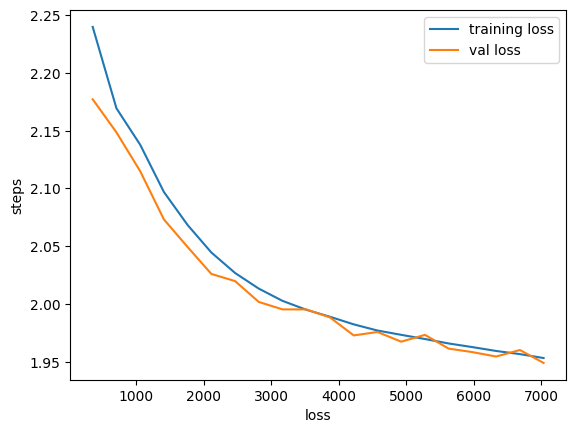

In [28]:
# plotting the  training and validation losses for cifar from scratch model
import os
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt


directory = "logs/scratchmodel/train"

directory_files = os.listdir(directory)

log_files = [file for file in directory_files if file.startswith("events.out.tfevents")]


for file in log_files:

  event_file = event_accumulator.EventAccumulator(os.path.join(directory, file))

  event_file.Reload()

  train_loss_values = [(event.step, event.value) for event in event_file.Scalars("train_loss_epoch")]

  train_steps, train_values = zip(*train_loss_values)

  plt.plot(train_steps, train_values, label=f"training loss")

  val_loss_values = [(event.step, event.value) for event in event_file.Scalars("val_loss")]

  val_steps, val_values = zip(*val_loss_values)

  plt.plot(val_steps, val_values, label=f"val loss")

  plt.xlabel("loss")
  plt.ylabel("steps")

  plt.legend()

  plt.show()

In [29]:
# testing the model
trainer_model_reg_cnn.test(model=cifar_model, dataloaders = test_data)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.3386029005050659     │
│         test_loss         │    1.9573066234588623     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.3386029005050659, 'test_loss': 1.9573066234588623}]

In [30]:
# saving cifar weights.
torch.save(cifar_model.state_dict(), "Cifar.ckpt")

In [31]:
# loading the pretrained model from the checkpoint

directory = "/content/lightning_logs/version_0/checkpoints"

directory_files = os.listdir(directory)

checkpoint_files = [file for file in directory_files if file.startswith("epoch")]

checkpoint = checkpoint_files[0]

pretrained_model = BasiccnnLightning.load_from_checkpoint(os.path.join(directory, checkpoint), classifier=basic_cnn)

pretrained_model.classifier

CNN(
  (normal_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_connected_layers): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
    (5): Sigmoid()
    (6): ReLU()
  )
)

In [32]:
# defining a new class TuneBasicCNN to fine tune the pretrained model
class TuneBasicCNN(nn.Module):
  def __init__(self, pretrained_model, n):
    super(TuneBasicCNN, self).__init__()
    self.classifier = pretrained_model
    self.classes_count = n

  def forward(self, x):
    x = self.classifier(x)
    return x

In [33]:
# check points and the early stopping
from lightning.pytorch.callbacks import ModelCheckpoint

model_checkpoint = l.callbacks.ModelCheckpoint(
    monitor = "val_loss",
    mode = "min"
)

early_stopping = l.callbacks.EarlyStopping(
    monitor = "val_loss",
    mode = "min",
    patience = 3
)

callback_s = [model_checkpoint, early_stopping]

In [34]:
# initializing the model
lightning_classifier = TuneBasicCNN(pretrained_model, 10)
tuned_lightning_classifier = BasiccnnLightning(lightning_classifier)

In [35]:
# fitting the model
trainer_model_tuned_lightning_classifier = l.Trainer(callbacks = callback_s, max_epochs = 20,logger=l.loggers.TensorBoardLogger("logs", name="tunedmodel", version="train"))
trainer_model_tuned_lightning_classifier.fit(model=tuned_lightning_classifier, train_dataloaders=train_data, val_dataloaders=val_data )


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type               | Params
--------------------------------------------------
0 | classifier | TuneBasicCNN       | 597 K 
1 | accuracy   | MulticlassAccuracy | 0     
--------------------------------------------------
597 K     Trainable params
0         Non-trainable params
597 K     Total params
2.392     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [36]:
print("val loss",trainer_model_tuned_lightning_classifier.callback_metrics["val_loss"])
print("train loss",trainer_model_tuned_lightning_classifier.callback_metrics["train_loss"])

val loss tensor(1.9528)
train loss tensor(1.9556)


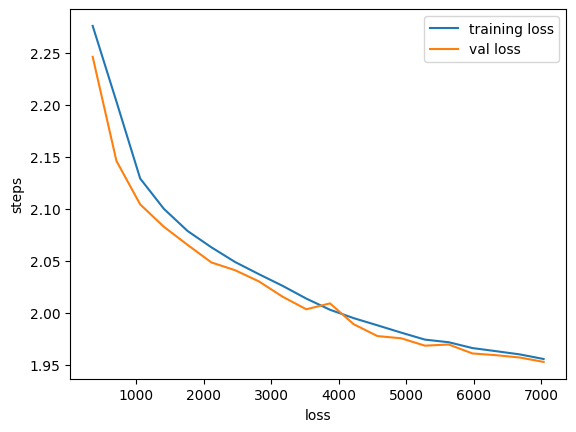

In [37]:
# plotting the train and val losses for cifar pretrained model
import os
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt


directory = "logs/tunedmodel/train"

directory_files = os.listdir(directory)

log_files = [file for file in directory_files if file.startswith("events.out.tfevents")]


for file in log_files:

  event_file = event_accumulator.EventAccumulator(os.path.join(directory, file))

  event_file.Reload()

  train_loss_values = [(event.step, event.value) for event in event_file.Scalars("train_loss_epoch")]

  train_steps, train_values = zip(*train_loss_values)

  plt.plot(train_steps, train_values, label=f"training loss")

  val_loss_values = [(event.step, event.value) for event in event_file.Scalars("val_loss")]

  val_steps, val_values = zip(*val_loss_values)

  plt.plot(val_steps, val_values, label=f"val loss")

  plt.xlabel("loss")
  plt.ylabel("steps")

  plt.legend()

  plt.show()


In [38]:
# testing the model
trainer_model_tuned_lightning_classifier.test(model=tuned_lightning_classifier, dataloaders=test_data)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.3297235667705536     │
│         test_loss         │    1.9584591388702393     │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.3297235667705536, 'test_loss': 1.9584591388702393}]

In [39]:
# saving the weights.
torch.save(tuned_lightning_classifier.state_dict(), "tuned_lightning_classifier.ckpt")